In [1]:
%matplotlib inline

import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

# Carbon Impulse Response Function (i.e. the baseline curve)

This section models two Impulse Reponse Functions (IRFs). An IRF represents the time-dependent fraction of an  emission pulse remaining in the atmosphere at time t. It is convenient to describe the IRF for a particular gas X by exponential functions:

$ IRF_x(t) = a_{x,0} + \sum_{i=1}^{3} a_{x,i} * e^{-t / tau_i} $

The $a$ and $tau$ parameters for CO2 can be taken from literature: 

- Joos, F., Roth, R., Fuglestvedt, J. S., Peters, G. P., Enting, I. G., von Bloh, W., Brovkin, V., Burke, E. J., Eby, M., Edwards, N. R., Friedrich, T., Frölicher, T. L., Halloran, P. R., Holden, P. B., Jones, C., Kleinen, T., Mackenzie, F. T., Matsumoto, K., Meinshausen, M., Plattner, G.-K., Reisinger, A., Segschneider, J., Shaffer, G., Steinacher, M., Strassmann, K., Tanaka, K., Timmermann, A., and Weaver, A. J.: Carbon dioxide and climate impulse response functions for the computation of greenhouse gas metrics: a multi-model analysis, Atmos. Chem. Phys., 13, 2793–2825, https://doi.org/10.5194/acp-13-2793-2013, 2013.

- Forster, P., V. Ramaswamy, P. Artaxo, T. Berntsen, R. Betts, D.W. Fahey, J. Haywood, J. Lean, D.C. Lowe, G. Myhre, J. Nganga, R. Prinn, G. Raga, M. Schulz and R. Van Dorland, 2007: Changes in Atmospheric Constituents and in Radiative Forcing. In: Climate Change 2007: The Physical Science Basis. Contribution of Working Group I to the Fourth Assessment Report of the Intergovernmental Panel on Climate Change [Solomon, S., D. Qin, M. Manning, Z. Chen, M. Marquis, K.B. Averyt, M.Tignor and H.L. Miller (eds.)]: https://www.ipcc.ch/site/assets/uploads/2018/02/ar4-wg1-chapter2-1.pdf (pg. 2013)

- IPCC: Special Report on Land Use, Land‐Use Change, and Forestry, Section 2.3.6.3, 2000, https://archive.ipcc.ch/ipccreports/sres/land_use/index.php?idp=74 and footnote https://archive.ipcc.ch/ipccreports/sres/land_use/fn3.htm#4


In [2]:
def IRF(t_horizon, curve):
    
    if curve == 'joos_2013':
        # parameters from Joos et al, 2013 (Table 5)
        a = [0.2173, 0.2240, 0.2824, 0.2763]
        tau = [0, 394.4, 36.54, 4.304]
    elif curve == 'ipcc_2007':
        # parameters from IPCC 2007 (page 213)
        a = [0.217, 0.259, 0.338, 0.186]
        tau = [0, 172.9, 18.51, 1.186]
    elif curve == 'ipcc_2000':
        # parameters from IPCC Special Report 2000
        a = [0.175602, 0.137467, 0.18576, 0.242302, 0.258868]
        tau = [0, 421.093, 70.5965, 21.42165, 3.41537]

    IRF = [a[0]] * len(t_horizon)
    for t in t_horizon:
        for i in np.arange(1,len(a)):
            IRF[t] =  IRF[t] + (a[i] * np.exp(-t/tau[i]))
    
    return IRF

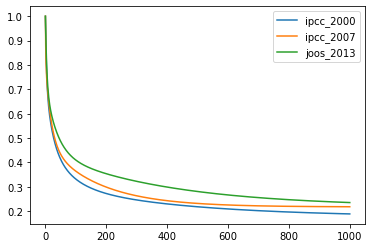

In [3]:
t_horizon = np.arange(1001)
ipcc_2000 = IRF(t_horizon, 'ipcc_2000')
ipcc_2007 = IRF(t_horizon, 'ipcc_2007')
joos_2013 = IRF(t_horizon, 'joos_2013')
plt.plot(t_horizon, ipcc_2000, label='ipcc_2000')
plt.plot(t_horizon, ipcc_2007, label='ipcc_2007')
plt.plot(t_horizon, joos_2013, label='joos_2013')
plt.legend()

Joos et al. (2013) report the following time-dependent fractions of an original pulse of CO2 remaining in the atmosphere in their results, section 4.1: 
- 0.6 +- 0.14 at year 20
- 0.4 +- 0.13 at year 100
- 0.25 +- 0.09 at year 1000

We can compare that to the joos_2013 curve we generated above: 

In [4]:
for curve in [joos_2013]:
    print('At t=20:   '+ str(round(curve[20],3)))
    print('At t=100:  '+ str(round(curve[100],3)))
    print('At t=1000: '+ str(round(curve[-1],3)))
    print()

At t=20:   0.596
At t=100:  0.409
At t=1000: 0.235



--> **what's going on at t=1000?** <--

# Ton-year benefit calculations

Check these against IPCC special report #s for the three methods (https://archive.ipcc.ch/ipccreports/sres/land_use/index.php?idp=74) with: 
- time horizon = 100
- baseline = ipcc_2000
- delay = 46

In [5]:
time_horizon = 100
delay = 46
baseline = ipcc_2000
scale = 1
discount_rate = 0

### Helpers

In [6]:
def discount(discount_rate, curve): 
    return [b/math.pow(1+discount_rate, i) for i,b in enumerate(curve)]

In [7]:
def print_benefit_report(delay, benefit, baseline_benefit, discount_rate=0):
    print()
    print('Delay: ' + str(delay) + ' years')
    if discount_rate > 0: 
        print('Discount rate: ' + str(discount_rate))
    print('Benefit: ' + str(round(benefit,2)) + ' ton-years')
    print('"Permanent" benefit: ' + str(round(baseline_benefit,2)) + ' ton-years')
    print('Permanent-equivalent achieved: ' + str(round(benefit/baseline_benefit,2)))
    print()

### Moura-Costa method

Calculates ton years via a simple equivalence b/w the carbon stored in the carbon stock ton-years to carbon curve ton-years

In [8]:
def moura_costa(time_horizon, baseline, delay, scale, discount_rate):
    t = np.arange(time_horizon+1)
    baseline = baseline[0:time_horizon+1]
    scenario = [-scale]*(delay+1) + [0]*(time_horizon-(delay))               
    benefit = -np.trapz(scenario[:delay+1])
    baseline_benefit = np.trapz(baseline)

    baseline_discounted = discount(discount_rate, baseline)
    scenario_discounted = discount(discount_rate, scenario)
    benefit_discounted = -np.trapz(scenario_discounted[:delay+1])
    baseline_benefit_discounted = np.trapz(baseline_discounted)
    
    return {'t': t,
            'scenario': scenario, 
            'baseline': baseline, 
            'benefit': benefit, 
            'baseline_benefit': baseline_benefit, 
            'scenario_discounted': scenario_discounted,
            'baseline_discounted': baseline_discounted,
            'benefit_discounted': benefit_discounted,
            'baseline_benefit_discounted': baseline_benefit_discounted}


Delay: 46 years
Benefit: 46.0 ton-years
"Permanent" benefit: 45.76 ton-years
Permanent-equivalent achieved: 1.01



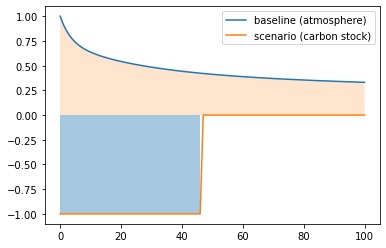

In [9]:
m = moura_costa(time_horizon, baseline, delay, scale, discount_rate)
print_benefit_report(delay, m['benefit'], m['baseline_benefit'], discount_rate)
plot = plt.plot(m['baseline'], label="baseline (atmosphere)")
plot = plt.plot(m['scenario'], label="scenario (carbon stock)")
plot = plt.fill_between(m['t'], m['scenario'], where=(np.array(m['scenario'])<0), alpha = 0.4)
plot = plt.fill_between(m['t'], m['baseline'], alpha = 0.2)
plot = plt.legend()

### Lashof method

In [10]:
def lashof(time_horizon, baseline, delay, scale=1, discount_rate=0): 
    t = np.arange(time_horizon + delay + 1)
    baseline = baseline[0:time_horizon+1] 
    scenario = [0]* delay + baseline
    scenario = [s*scale for s in scenario]
    baseline = baseline + [0]*delay
    benefit = np.trapz(scenario[time_horizon:])
    baseline_benefit = np.trapz(baseline)

    baseline_discounted = discount(discount_rate, baseline)
    scenario_discounted = discount(discount_rate, scenario)
    benefit_discounted = np.trapz(scenario_discounted[time_horizon:])
    baseline_benefit_discounted = np.trapz(baseline_discounted)
    
    return {'t': t,
            'scenario': scenario, 
            'baseline': baseline, 
            'benefit': benefit, 
            'baseline_benefit': baseline_benefit, 
            'scenario_discounted': scenario_discounted,
            'baseline_discounted': baseline_discounted,
            'benefit_discounted': benefit_discounted, 
            'baseline_benefit_discounted': baseline_benefit_discounted}


Delay: 46 years
Benefit: 16.64 ton-years
"Permanent" benefit: 45.93 ton-years
Permanent-equivalent achieved: 0.36



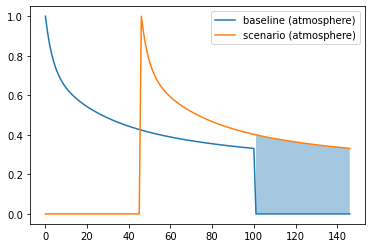

In [11]:
l = lashof(time_horizon, baseline, delay)
print_benefit_report(delay, l['benefit'], l['baseline_benefit'], discount_rate)
plot = plt.plot(l['baseline'], label="baseline (atmosphere)")
plot = plt.plot(l['scenario'], label="scenario (atmosphere)")
plot = plt.fill_between(l['t'], l['scenario'], where=(l['t']>time_horizon), alpha = 0.4)
plot = plt.legend()

### IPCC method 

Take into account full re-emission; comparison of atmophere in measurement scenario and counterfactual

In [12]:
def ipcc(time_horizon, baseline, delay, scale=1, discount_rate=0):
    t = np.arange(time_horizon+1)
    baseline = baseline[0:time_horizon+1]
    scenario = [0]*(delay+1) + baseline[0:(time_horizon-(delay))]
    scenario = [s*scale for s in scenario]
    benefit = np.trapz(baseline) - np.trapz(scenario)
    baseline_benefit = np.trapz(baseline) 
       
    baseline_discounted = discount(discount_rate, baseline)
    scenario_discounted = discount(discount_rate, scenario)
    benefit_discounted = np.trapz(baseline_discounted) - np.trapz(scenario_discounted)
    baseline_benefit_discounted = np.trapz(baseline_discounted)
    
    return {'t': t, 
            'scenario': scenario, 
            'baseline': baseline, 
            'benefit': benefit, 
            'baseline_benefit': baseline_benefit, 
            'scenario_discounted': scenario_discounted,
            'baseline_discounted': baseline_discounted,
            'benefit_discounted': benefit_discounted, 
            'baseline_benefit_discounted': baseline_benefit_discounted}


Delay: 46 years
Benefit: 16.54 ton-years
"Permanent" benefit: 45.76 ton-years
Permanent-equivalent achieved: 0.36



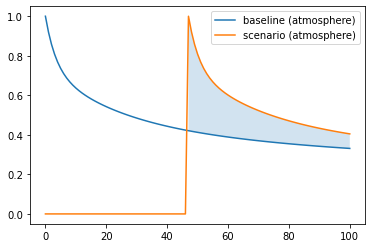

In [13]:
i = ipcc(time_horizon, baseline, delay)
print_benefit_report(delay, i['benefit'], i['baseline_benefit'], discount_rate)
plot = plt.plot(i['baseline'], label="baseline (atmosphere)")
plot = plt.plot(i['scenario'], label="scenario (atmosphere)")
plot = plt.fill_between(i['t'], i['baseline'], i['scenario'], where=np.array(i['scenario']) > np.array(i['baseline']), alpha=0.2) 
plot = plt.legend()

# Case Study: NCX 

Moura-costa method? 

- Time horizon: 100 years
- 1 tCO2e equivalency: 48 ton-years, citing IPCC 2007
- Discount rate: 3.3% → 17 ton-years today = 48 ton-years over 100 year

See "Forest and Carbon: A Guide for Buyers and Policymakers", p.21-24 for a description of the NCX ton-year accounting method: https://ncx.com/wp-content/uploads/2021/06/Forests-and-Carbon_A-Guide-for-Buyers-and-Policymakers_SilviaTerra2020_v0.4-2-1.pdf 

In [14]:
time_horizon = 100
delay = 1
scale = 17
discount_rate = 0.033

ncx = moura_costa(time_horizon, baseline, delay, scale, discount_rate)
print_benefit_report(delay, ncx['benefit'], ncx['baseline_benefit'])


Delay: 1 years
Benefit: 17.0 ton-years
"Permanent" benefit: 45.76 ton-years
Permanent-equivalent achieved: 0.37




Delay: 1 years
Discount rate: 0.033
Benefit: 17.0 ton-years
"Permanent" benefit: 16.83 ton-years
Permanent-equivalent achieved: 1.01



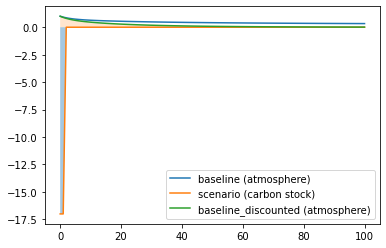

In [15]:
print_benefit_report(delay, ncx['benefit'], ncx['baseline_benefit_discounted'], discount_rate)
plot = plt.plot(ncx['baseline'], label="baseline (atmosphere)")
plot = plt.plot(ncx['scenario'], label="scenario (carbon stock)")
plot = plt.plot(ncx['baseline_discounted'], label="baseline_discounted (atmosphere)")
plot = plt.fill_between(ncx['t'], ncx['scenario'], where=(np.array(m['scenario'])<0), alpha = 0.4)
plot = plt.fill_between(ncx['t'], ncx['baseline_discounted'], alpha = 0.2)
plot = plt.legend()

### Cost sensitivity

Imagine the cost carbon credit is $10/permanent ton, where a 'permanent ton' is a handful of ton-years packaged up according to the NCX methodology. Since a 'permanent ton' = 17 ton-years, we can say that each ton-year costs: 59 cents. We can then ask, how does the cost of a 'permanent ton' change if the cost of a ton-year is reflects something true about taking an action today, and we change the methodology or parameters for calculating the equivalence between ton-years and permanent tons?

In [16]:
ton_year_cost = 10/17
round(ton_year_cost,2)

0.59

Imagine that instead of using a discount rate of 3.3%, NCX was using a discount rate of 2% or 5%. In the moura costa method, NCX would need to 

In [17]:
for d in [0.02, 0.05]:
    ncx = moura_costa(time_horizon, baseline, delay, scale=1, discount_rate=d)
    equivalence = ncx['baseline_benefit_discounted']
    print('Discount rate: ' + str(d))
    print('Number of tons needed today for equivalence: '+ str(ncx['baseline_benefit_discounted']))
    print('Cost of permanent ton: $' + str(round(ton_year_cost * ncx['baseline_benefit_discounted'],2)))
    print()

Discount rate: 0.02
Number of tons needed today for equivalence: 22.92995227165563
Cost of permanent ton: $13.49

Discount rate: 0.05
Number of tons needed today for equivalence: 12.494765668785082
Cost of permanent ton: $7.35



If no discount is applied, the time horizon can also have a large effect on the cost of a 'permanent' ton. For instance: 

Time horizon: 100
Number of tons needed today for equivalence: 45.76289499601616
Cost of permanent ton: $26.92

Time horizon: 200
Number of tons needed today for equivalence: 75.43054816071503
Cost of permanent ton: $44.37

Time horizon: 500
Number of tons needed today for equivalence: 147.2161504699034
Cost of permanent ton: $86.6

Time horizon: 1000
Number of tons needed today for equivalence: 247.299021242553
Cost of permanent ton: $145.47



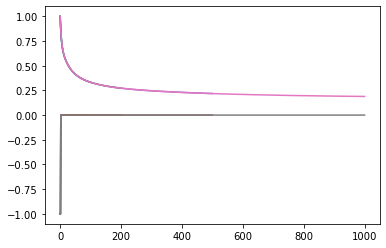

In [18]:
for t in [100, 200, 500, 1000]:
    ncx = moura_costa(t, baseline, delay, scale=1, discount_rate=0)
    plot = plt.plot(ncx['baseline'], label="baseline (atmosphere)")
    plot = plt.plot(ncx['scenario'], label="scenario (carbon stock)")
    equivalence = ncx['baseline_benefit_discounted']/ncx['benefit']
    print('Time horizon: ' + str(t))
    print('Number of tons needed today for equivalence: '+ str(equivalence))
    print('Cost of permanent ton: $' + str(round(ton_year_cost * equivalence,2)))
    print()

If instead the discount rate stayed as is, but the method is changed to reflect what happens to the tons after the 1 year storage period:


Delay: 1 years
Discount rate: 0.033
Benefit: 0.16 ton-years
"Permanent" benefit: 16.83 ton-years
Permanent-equivalent achieved: 0.01

Number of tons needed today for equivalence: 102.20612233520042
Cost of permanent ton: $60.12



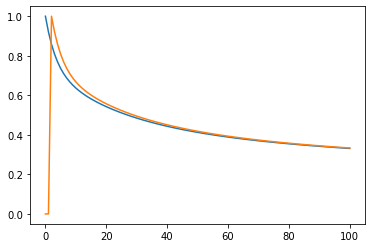

In [19]:
ncx = ipcc(time_horizon, baseline, delay, scale=1, discount_rate=0.033)
print_benefit_report(delay, ncx['benefit'], ncx['baseline_benefit_discounted'], discount_rate)
plot = plt.plot(ncx['baseline'], label="baseline (atmosphere)")
plot = plt.plot(ncx['scenario'], label="scenario (carbon stock)")
equivalence = ncx['baseline_benefit_discounted']/ncx['benefit']
print('Number of tons needed today for equivalence: '+ str(equivalence))
print('Cost of permanent ton: $' + str(round(ton_year_cost * equivalence,2)))
print()